In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)    

from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import config
import torch

In [2]:
from dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
X, y = dataset.get(dataframe=False)

In [78]:
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class AuxDataset(Dataset):
    def __init__(self, dataset_dir, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(AuxDataset, self).__init__()
        dataset = DermaDataset(dataset_dir)
        self.X, self.y = dataset.get(dataframe=False)
        self.X, self.y = torch.tensor(self.X, dtype=torch.float), torch.tensor(self.y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

dataset = AuxDataset(dataset_dir, None)
val_size = 512
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-val_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False)

In [189]:
from Sparse import KWinners
from torch import nn

# model = nn.Sequential(*[
#     nn.Conv1d(1,1,1, bias=False),
#     nn.Flatten(1),
#     KWinners(116, 50),    
#     nn.Linear(116, 256),
#     nn.ReLU(),
#     nn.Linear(256, 64),
#     nn.ReLU(),
#     nn.Linear(64, 2),
# ])

model = nn.Sequential(*[
    nn.Conv1d(1,1,1, bias=False),
    nn.Flatten(1),
    KWinners(116, 25),    
    nn.Linear(116, 256),
    nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(256, 116),
    nn.Sigmoid()
])

In [190]:
from tqdm import tqdm

n_epoch = 4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9, weight_decay=1e-6)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

model.train()
for epoch in epoch_iterator:
    for input, target in train_loader:
        input = input.to(device)
        target = target.to(device)

        out = model(input[:, None, :])
        # loss = criterion(out, target)
        loss = criterion(out, input) + 1e-1*torch.diff(out, 1).abs().mean() # Including total variation regularization

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 4/4 [00:06<00:00,  1.52s/epoch, tls=0.0077]


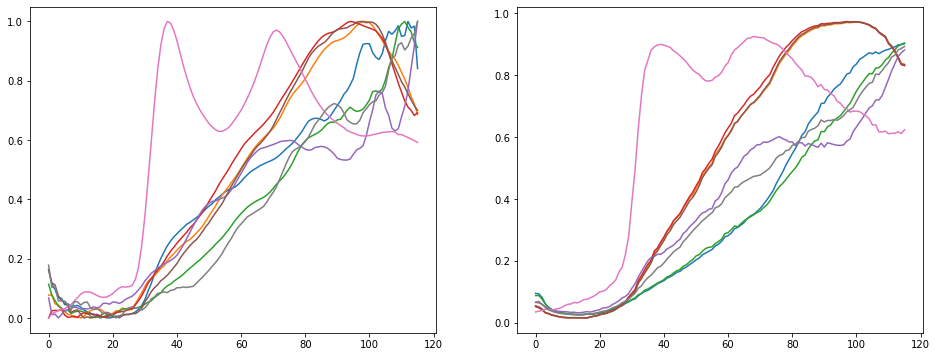

In [191]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:, None, :].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::64,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::64,:].T)
plt.show()


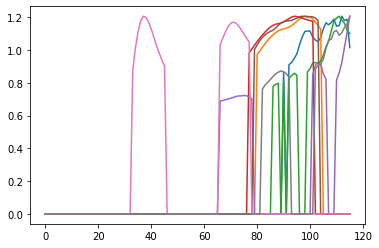

In [192]:
model.eval()
with torch.no_grad():
    input = input.to(device)
    out = model[:3](input[:, None, :])
plt.plot(out[::64].detach().cpu().numpy().T)
plt.show()

In [151]:
model[0].weight.data.cpu().numpy()

array([[[0.39643034]]], dtype=float32)

(array([2., 0., 2., 1., 0., 1., 0., 1., 1., 2., 2., 3., 1., 3., 3., 3.]),
 array([1.5704551, 1.5851907, 1.5999262, 1.6146618, 1.6293974, 1.6441331,
        1.6588687, 1.6736042, 1.6883398, 1.7030754, 1.717811 , 1.7325466,
        1.7472823, 1.7620178, 1.7767534, 1.791489 , 1.8062246],
       dtype=float32),
 <BarContainer object of 16 artists>)

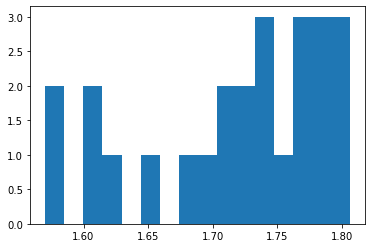

In [180]:
values = out[0].detach().cpu().flatten().numpy()

plt.hist(values[values!=0],bins=16)

(array([2., 2., 1., 0., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 4.]),
 array([1.6730278, 1.6813526, 1.6896774, 1.6980021, 1.706327 , 1.7146518,
        1.7229766, 1.7313013, 1.7396262, 1.747951 , 1.7562758, 1.7646005,
        1.7729254, 1.7812502, 1.789575 , 1.7978997, 1.8062246],
       dtype=float32),
 <BarContainer object of 16 artists>)

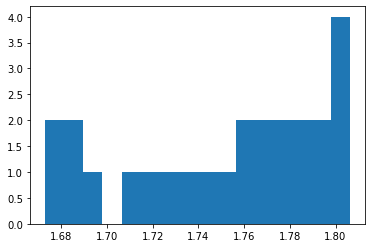

In [181]:
values = out[9].detach().cpu().flatten().numpy()

plt.hist(values[values!=0], bins=16)